## 4.3 データを取得する

1. house Pricesコンペのページkらでーたをダウンロードする
2. ディレクトリ構成
3. 必要なライブラリをインポートする
4. ランダムシードの設定
5. CSVデータを読み込む

In [245]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [246]:
plt.style.use('ggplot')

In [247]:
# ランダムシードの設定
import random

np.random.seed(1234)
random.seed(1234)

In [248]:
# CSVデータを読み込む

train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

In [249]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 4.4 ベースライン（ベンチマーク）を作成する

1. LightBGMで予測する
   1. 学習データの各変数の型を確認する
   2. 学習データとテストデータの連結して前処理を行う
   3. カテゴリ変数を数値に変換する
   4. 欠損値を数値に変換する
   5. 再び学習データとテストデータに戻す
   6. LightGBMに上記データを読み込ませる
2. クロスバリデーションを用いてモデルの学習・予測を行う
   1. クロスバリデーション用のライブラリを読み込んで分割数を設定する
      1. ハイパーパラメータを設定する
      2. 説明変数、目的変数を指定する
      3. 平均二乗誤差を出すライブラリをインポートする
      4. 各foldごとに作成したモデルごとの予測値を保存する
      5. 平均RMSEを計算する
      6. 現状の予測値と実際の値の違いを確認する
   2. 各変数の重要度を確認する
      1. 表示する変数の数を制限する

In [250]:
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [251]:
train_df["MSZoning"].value_counts()

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

In [252]:
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

all_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


In [253]:
all_df["SalePrice"]

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
2914         NaN
2915         NaN
2916         NaN
2917         NaN
2918         NaN
Name: SalePrice, Length: 2919, dtype: float64

In [254]:
from sklearn.preprocessing import LabelEncoder

In [255]:
categories = all_df.columns[all_df.dtypes == 'object']

print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [256]:
all_df["Alley"].value_counts()

Alley
Grvl    120
Pave     78
Name: count, dtype: int64

In [257]:
for cat in categories:
    le = LabelEncoder()
    print(cat)

    all_df[cat].fillna("missing", inplace=True)
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype("category")

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


/var/folders/pt/v29l1vwx7c3_45d3f_v8knlm0000gn/T/ipykernel_57347/2639677646.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df[cat].fillna("missing", inplace=True)
/var/folders/pt/v29l1vwx7c3_45d3f_v8knlm0000gn/T/ipykernel_57347/2639677646.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

In [258]:
all_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,3,4,4,0,2,2008,8,4,208500.0
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,3,4,4,0,5,2007,8,4,181500.0
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,3,4,4,0,9,2008,8,4,223500.0
3,4,70,3,60.0,9550,1,2,0,3,0,...,0,3,4,4,0,2,2006,8,0,140000.0
4,5,60,3,84.0,14260,1,2,0,3,0,...,0,3,4,4,0,12,2008,8,4,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,4,21.0,1936,1,2,3,3,0,...,0,3,4,4,0,6,2006,8,4,NaN
2915,2916,160,4,21.0,1894,1,2,3,3,0,...,0,3,4,4,0,4,2006,8,0,NaN
2916,2917,20,3,160.0,20000,1,2,3,3,0,...,0,3,4,4,0,9,2006,8,0,NaN
2917,2918,85,3,62.0,10441,1,2,3,3,0,...,0,3,2,2,700,7,2006,8,4,NaN


In [259]:
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]

In [260]:
import lightgbm as lgb
from sklearn.model_selection import KFold

In [261]:
folds = 3
kf = KFold(n_splits=folds)

In [262]:
lgbm_params = {
    "objective": "regression",
    "random_seed": 1234,
}

In [263]:
train_X = train_df_le.drop(["SalePrice", "Id"], axis=1)
train_Y = train_df_le["SalePrice"]

In [264]:
from sklearn.metrics import mean_squared_error

In [265]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train, X_valid = train_X.iloc[train_index], train_X.iloc[val_index]
    y_train, y_valid = train_Y.iloc[train_index], train_Y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    model_lgb = lgb.train(
        lgbm_params,
        lgb_train,
        valid_sets=lgb_eval,
        num_boost_round=100,
        callbacks=[lgb.log_evaluation(period=100), lgb.early_stopping(stopping_rounds=20)],
        )
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_pred)))

    print(tmp_rmse)
    
    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2963
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Info] Start training from score 179726.031860
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's l2: 5.37132e+08
0.12800381488672496
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2984
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Info] Start training from score 180923.739979
Training until validation scores don't improve for 20 rounds
[100]	valid_0's l2: 8.94106e+08
Did no

In [266]:
sum(rmses) / len(rmses)

np.float64(0.1352849504777467)

In [267]:
del rmses

In [268]:
# len(rmses)

In [269]:
actual_pred_df = pd.DataFrame({
    "actual": train_Y,
    "pred": oof
})

<Axes: >

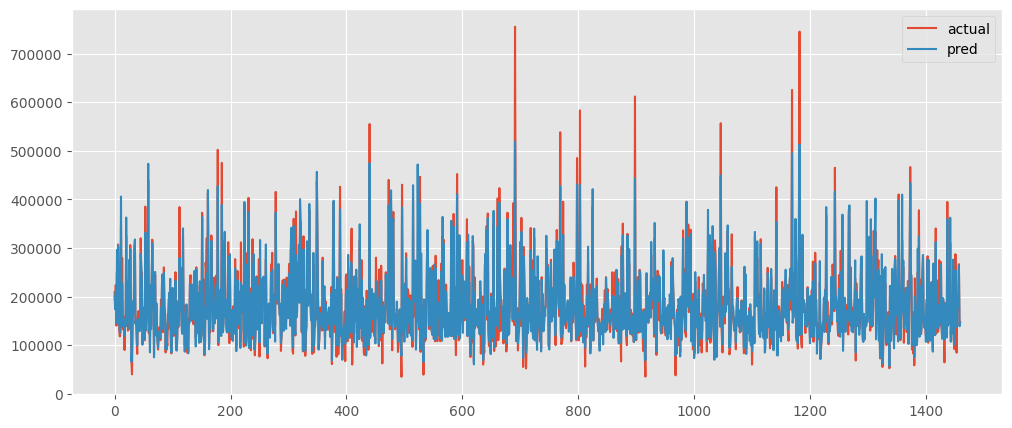

In [270]:
actual_pred_df.plot(figsize=(12, 5))

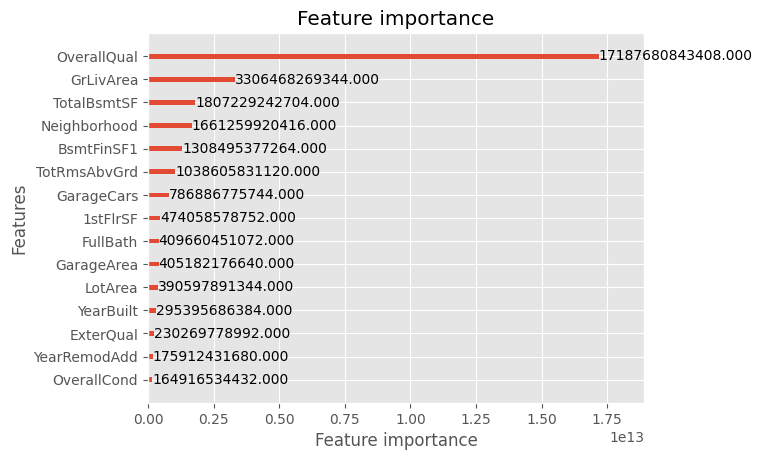

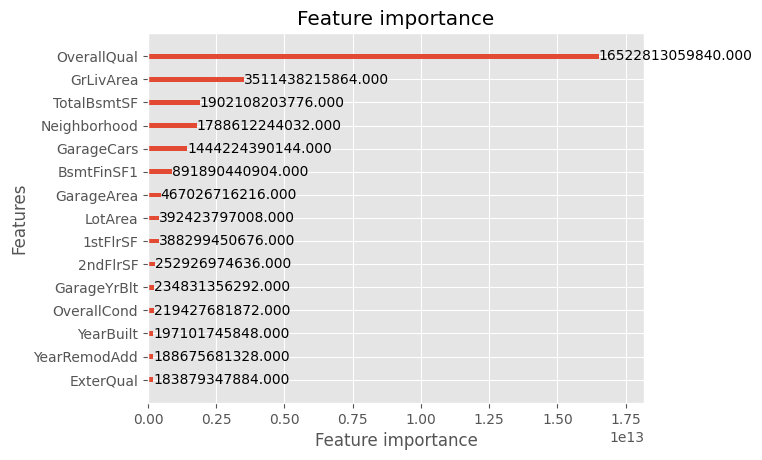

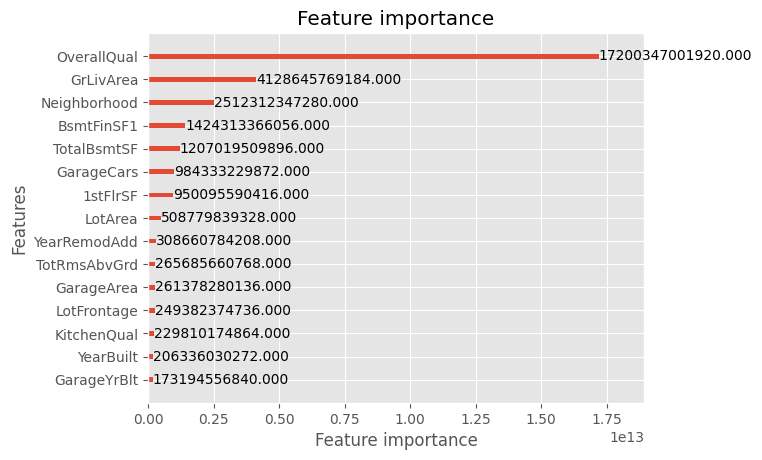

In [271]:
for model in models:
    lgb.plot_importance(model, importance_type="gain", max_num_features=15)

## 4.5 目的変数の前処理：目的変数の分布を確認する

1. SalePriceのでーたの分布を確認する
   1. SalePriceの各統計量を確認する
   2. ヒストグラムでSalePriceの分布を確認する
   3. 目的変数を対数化する
   4. 目的変数の対数化による予測精度の向上を確認する

In [272]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: ylabel='Frequency'>

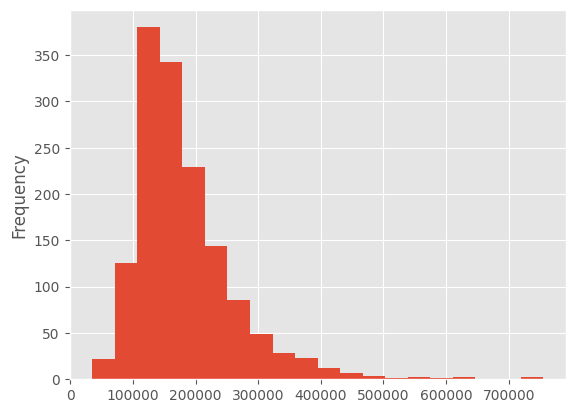

In [273]:
train_df["SalePrice"].plot.hist(bins=20)

In [274]:
np.log(train_df['SalePrice'])

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

<Axes: ylabel='Frequency'>

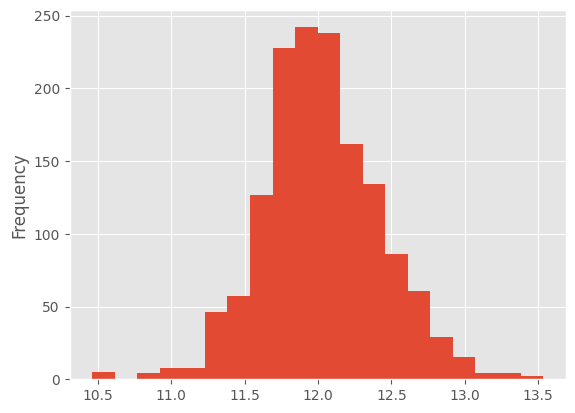

In [275]:
np.log(train_df['SalePrice']).plot.hist(bins=20)

In [276]:
train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])

/var/folders/pt/v29l1vwx7c3_45d3f_v8knlm0000gn/T/ipykernel_57347/2708461522.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])


In [277]:
train_X = train_df_le.drop(["SalePrice", "SalePrice_log", "Id"], axis=1)

train_Y = train_df_le["SalePrice_log"]

In [278]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train, X_valid = train_X.iloc[train_index], train_X.iloc[val_index]
    y_train, y_valid = train_Y.iloc[train_index], train_Y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    model_lgb = lgb.train(
        lgbm_params, 
        lgb_train, 
        valid_sets=lgb_eval, 
        num_boost_round=100, 
        callbacks=[
            lgb.early_stopping(stopping_rounds=20), 
            lgb.log_evaluation(period=10)
            ]
        )
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

    print(tmp_rmse)

    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2963
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 74
[LightGBM] [Info] Start training from score 12.017607
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0436707
[20]	valid_0's l2: 0.0222385
[30]	valid_0's l2: 0.0180434
[40]	valid_0's l2: 0.016907
[50]	valid_0's l2: 0.0165714
[60]	valid_0's l2: 0.0163693
[70]	valid_0's l2: 0.0162283
[80]	valid_0's l2: 0.0161985
[90]	valid_0's l2: 0.0160713
[100]	valid_0's l2: 0.0161346
Did not meet early stopping. Best iteration is:
[90]	valid_0's l2: 0.0160713
0.12677276183461025
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2984
[LightGBM] [Inf

In [279]:
sum(rmses) / len(rmses)

np.float64(0.13179298123488878)

## 4.6 説明変数の前処理：欠損値を確認する

1. 各説明変数の欠損値を確認する
   1. all_dfを作成する
   2. 欠損値の数が上位40の変数を確認する
   3. 欠損値の多い高級住宅設備に関する変数をまとめる

In [280]:
# 1-1
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

In [281]:
categories = all_df.columns[all_df.dtypes == "object"]
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [282]:
# 1-2
all_df.isnull().sum().sort_values(ascending=False).head(40)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
MasVnrType       1766
SalePrice        1459
FireplaceQu      1420
LotFrontage       486
GarageYrBlt       159
GarageFinish      159
GarageQual        159
GarageCond        159
GarageType        157
BsmtExposure       82
BsmtCond           82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrArea         23
MSZoning            4
Functional          2
BsmtFullBath        2
Utilities           2
BsmtHalfBath        2
Electrical          1
TotalBsmtSF         1
BsmtUnfSF           1
KitchenQual         1
BsmtFinSF2          1
BsmtFinSF1          1
SaleType            1
GarageCars          1
Exterior2nd         1
Exterior1st         1
GarageArea          1
YrSold              0
Fireplaces          0
MoSold              0
MiscVal             0
SaleCondition       0
dtype: int64

In [283]:
# 1-3
all_df.PoolQC.value_counts()

PoolQC
Ex    4
Gd    4
Fa    2
Name: count, dtype: int64

In [284]:
all_df.loc[~all_df["PoolQC"].isnull(), "PoolQC"] = 1
all_df.loc[all_df["PoolQC"].isnull(), "PoolQC"] = 0

In [285]:
all_df.PoolQC.value_counts()

PoolQC
0    2909
1      10
Name: count, dtype: int64

In [286]:
all_df.loc[~all_df["MiscFeature"].isnull(), "MiscFeature"] = 1
all_df.loc[all_df["MiscFeature"].isnull(), "MiscFeature"] = 0

In [287]:
all_df.loc[~all_df["Alley"].isnull(), "Alley"] = 1
all_df.loc[all_df["Alley"].isnull(), "Alley"] = 0

In [288]:
HighFacility_col = ["PoolQC", "MiscFeature", "Alley"]
for col in HighFacility_col:
    if all_df[col].dtype == "object":
        if len(all_df[all_df[col].isnull()]) > 0:
            all_df.loc[~all_df[col].isnull(), col] = 1
            all_df.loc[all_df[col].isnull(), col] = 0

In [289]:
all_df["hasHighFacility"] = all_df["PoolQC"] + all_df["MiscFeature"] + all_df["Alley"]
all_df["hasHighFacility"] = all_df["hasHighFacility"].astype(int)
all_df["hasHighFacility"].value_counts()

hasHighFacility
0    2615
1     295
2       9
Name: count, dtype: int64

In [290]:
all_df = all_df.drop(["PoolQC", "MiscFeature", "Alley"], axis=1)

## 4.7 外れ値を除外する

1. 外れ値とは
2. 各説明変数のデータの分布を確認する
   1. 各変数の統計量を確認する
   2. 数値データのみを抜き出す
   3. 多数のデータが0（ゼロ）の値である変数を確認する
   4. ある特定の値のみを持つ変数を確認する
   5. 外れ値があるか確認する
   6. 外れ値を含む変数の分布を可視化する
   7. 前処理した学習データでRMSEを計算する

In [291]:
# 2-1
all_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,2919.0,1460.000000,842.787043,1.0,730.5,1460.0,2189.5,2919.0
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.0,368.5,733.0,5644.0


In [292]:
# 2-2
train_df_num = train_df.select_dtypes(include=[np.number])

In [293]:
nonratio_features = [
    "Id",
    "MSSubClass",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "MoSold",
    "YrSold"
]

In [294]:
num_features = sorted(list(set(train_df_num) - set(nonratio_features)))

In [295]:
num_features

['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MasVnrArea',
 'MiscVal',
 'OpenPorchSF',
 'PoolArea',
 'SalePrice',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF']

In [296]:
train_df_num_rs = train_df_num[num_features]

In [297]:
# 2-3
for col in num_features:
    if train_df_num_rs.describe()[col]["75%"] == 0:
        print(col, len(train_df_num_rs[train_df_num_rs[col] == 0]))

3SsnPorch 1436
BsmtFinSF2 1293
BsmtHalfBath 1378
EnclosedPorch 1252
LowQualFinSF 1434
MiscVal 1408
PoolArea 1453
ScreenPorch 1344


In [298]:
# 2-4
for col in num_features:
    if train_df_num_rs[col].nunique() < 15:
        print(col, train_df_num_rs[col].nunique())

BedroomAbvGr 8
BsmtFullBath 4
BsmtHalfBath 3
Fireplaces 4
FullBath 4
GarageCars 5
HalfBath 3
KitchenAbvGr 4
PoolArea 8
TotRmsAbvGrd 12


In [299]:
# 2-5
for col in num_features:
    tmp_df = train_df_num_rs[
        (train_df_num_rs[col] > train_df_num_rs[col].mean() + train_df_num_rs[col].std()*3) | \
        (train_df_num_rs[col] < train_df_num_rs[col].mean() - train_df_num_rs[col].std()*3)
    ]
    print(col, len(tmp_df))

1stFlrSF 12
2ndFlrSF 4
3SsnPorch 23
BedroomAbvGr 14
BsmtFinSF1 6
BsmtFinSF2 50
BsmtFullBath 16
BsmtHalfBath 82
BsmtUnfSF 11
EnclosedPorch 51
Fireplaces 5
FullBath 0
GarageArea 7
GarageCars 0
GarageYrBlt 1
GrLivArea 16
HalfBath 12
KitchenAbvGr 68
LotArea 13
LotFrontage 12
LowQualFinSF 20
MasVnrArea 32
MiscVal 8
OpenPorchSF 27
PoolArea 7
SalePrice 22
ScreenPorch 55
TotRmsAbvGrd 12
TotalBsmtSF 10
WoodDeckSF 22


<Axes: xlabel='BsmtFinSF1', ylabel='SalePrice'>

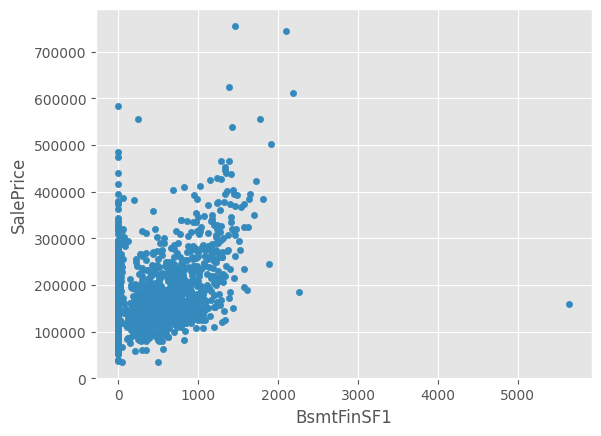

In [300]:
# 2-6
all_df.plot.scatter(x="BsmtFinSF1", y="SalePrice")

In [301]:
all_df[all_df["BsmtFinSF1"] > 5000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1


<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

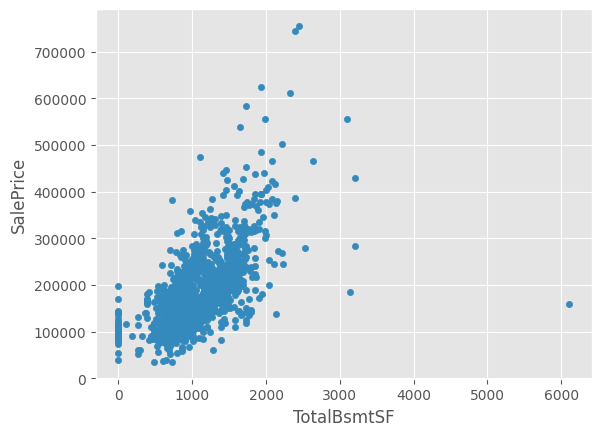

In [302]:
all_df.plot.scatter(x="TotalBsmtSF", y="SalePrice")

In [303]:
all_df[all_df["TotalBsmtSF"] > 6000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1


<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

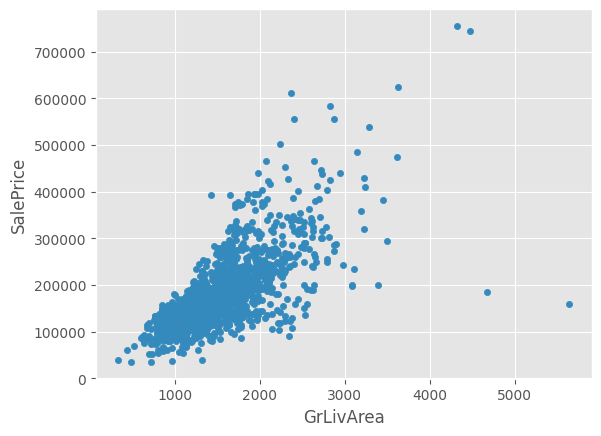

In [304]:
all_df.plot.scatter(x="GrLivArea", y="SalePrice")

In [305]:
all_df[all_df["GrLivArea"] > 5000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1
2549,2550,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,NaN,17000,10,2007,New,Partial,NaN,0


<Axes: xlabel='1stFlrSF', ylabel='SalePrice'>

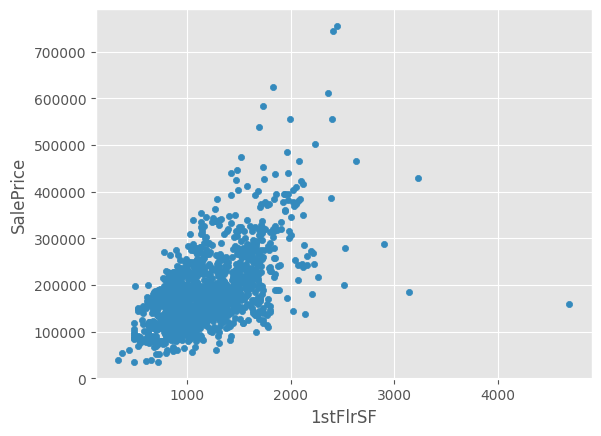

In [306]:
all_df.plot.scatter(x="1stFlrSF", y="SalePrice")

In [307]:
all_df[all_df["1stFlrSF"] > 4000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1
2549,2550,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,NaN,17000,10,2007,New,Partial,NaN,0


In [308]:
all_df = all_df[(all_df['BsmtFinSF1'] < 2000) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['TotalBsmtSF'] < 3000) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['GrLivArea'] < 4500) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['1stFlrSF'] < 2500) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df['LotArea'] < 100000) | (all_df['SalePrice'].isnull())]

In [309]:
# 2-7
categories = categories.drop(["PoolQC","MiscFeature","Alley"])

In [310]:
for cat in categories:
    le = LabelEncoder()
    print(cat)
    
    all_df[cat].fillna("missing", inplace=True)    
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype("category")

MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
Fence
SaleType
SaleCondition


/var/folders/pt/v29l1vwx7c3_45d3f_v8knlm0000gn/T/ipykernel_57347/1324708307.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df[cat].fillna("missing", inplace=True)
/var/folders/pt/v29l1vwx7c3_45d3f_v8knlm0000gn/T/ipykernel_57347/1324708307.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

In [311]:
train_df_le = all_df[~all_df["SalePrice"].isnull()] 
test_df_le = all_df[all_df["SalePrice"].isnull()] 

train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice","SalePrice_log", "Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

/var/folders/pt/v29l1vwx7c3_45d3f_v8knlm0000gn/T/ipykernel_57347/4056100210.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])


In [312]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(
        lgbm_params, 
        lgb_train, 
        valid_sets=lgb_eval, 
        num_boost_round=100, 
        callbacks=[
            lgb.early_stopping(stopping_rounds=20), 
            lgb.log_evaluation(period=10)
            ]
        )
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2948
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 72
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0423077
[20]	valid_0's l2: 0.0217695
[30]	valid_0's l2: 0.017511
[40]	valid_0's l2: 0.0162447
[50]	valid_0's l2: 0.0161528
[60]	valid_0's l2: 0.0160055
[70]	valid_0's l2: 0.0160335
[80]	valid_0's l2: 0.0160276
[90]	valid_0's l2: 0.0160347
[100]	valid_0's l2: 0.0160414
Did not meet early stopping. Best iteration is:
[98]	valid_0's l2: 0.0159996
0.12648953494655646
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2942
[LightGBM] [Inf

In [313]:
sum(rmses) / len(rmses)

np.float64(0.12956644378893936)

## 4.8 説明変数の確認: 特徴量を生成する

1. 時間に関する変数の統計量を確認する
2. 時間に関する変数を組み合わせて新たな特徴量を作成する
3. 広さ関連の変数から新たな特徴量を作成する

In [314]:
# 4-1
all_df[["YearBuilt", "YearRemodAdd", "GarageYrBlt", "YrSold"]].describe()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
count,2904.000000,2904.000000,2745.000000,2904.000000
mean,1971.234504,1984.217975,1978.061202,2007.792011
std,30.319059,20.907346,25.600996,1.316366
min,1872.000000,1950.000000,1895.000000,2006.000000
25%,1953.000000,1965.000000,1960.000000,2007.000000
50%,1973.000000,1993.000000,1979.000000,2008.000000
75%,2001.000000,2004.000000,2002.000000,2009.000000
max,2010.000000,2010.000000,2207.000000,2010.000000


In [315]:
# 4-2
all_df["Age"] = all_df["YrSold"] - all_df["YearBuilt"]

In [316]:
sum(rmses) / len(rmses)

np.float64(0.12956644378893936)

In [317]:
# 4-3 広さ関連の変数から新たな特徴量を作成する
all_df[
    ["LotArea","MasVnrArea","BsmtUnfSF","TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", "GarageArea","WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "LotFrontage"]
    ].describe()

,LotArea,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,LotFrontage
count,2904.000000,2882.000000,2903.000000,2903.000000,2904.000000,2904.000000,2904.000000,2904.000000,2903.000000,2904.000000,2904.000000,2904.000000,2904.000000,2904.000000,2904.000000,2425.000000
mean,9912.604683,101.191187,559.850499,1043.794006,1152.707300,336.355372,4.718664,1493.781336,471.632794,93.265840,47.226584,22.988636,2.615702,16.086777,1.907025,69.071340
std,5178.128224,177.804595,438.438879,420.008348,377.291394,427.355787,46.515308,491.149725,214.551791,125.855568,67.195477,64.055325,25.252464,56.245764,33.082892,22.662001
min,1300.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
25%,7448.250000,0.000000,220.000000,791.500000,875.750000,0.000000,0.000000,1124.000000,319.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59.000000
50%,9422.000000,0.000000,467.000000,988.000000,1080.000000,0.000000,0.000000,1441.000000,478.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,68.000000
75%,11503.000000,164.000000,802.500000,1296.000000,1381.250000,704.000000,0.000000,1739.250000,576.000000,168.000000,69.250000,0.000000,0.000000,0.000000,0.000000,80.000000
max,70761.000000,1600.000000,2336.000000,5095.000000,5095.000000,1872.000000,1064.000000,5095.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,313.000000


In [318]:
all_df["TotalSF"] = all_df["TotalBsmtSF"] + all_df["1stFlrSF"] + all_df["2ndFlrSF"]
all_df["Total_Bathrooms"] = all_df["FullBath"] + all_df["HalfBath"] + all_df["BsmtFullBath"] + all_df["BsmtHalfBath"]

In [319]:
all_df["Total_PorchSF"] = all_df["WoodDeckSF"] + all_df["OpenPorchSF"] + all_df["EnclosedPorch"] + all_df["3SsnPorch"] + all_df["ScreenPorch"]

In [320]:
all_df["hasPorch"] = all_df["Total_PorchSF"].apply(lambda x: 1 if x > 0 else 0)
all_df = all_df.drop("Total_PorchSF",axis=1)

In [321]:
train_df_le = all_df[~all_df["SalePrice"].isnull()] 
test_df_le = all_df[all_df["SalePrice"].isnull()] 

train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

/var/folders/pt/v29l1vwx7c3_45d3f_v8knlm0000gn/T/ipykernel_57347/3064488328.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])


In [322]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    # model_lgb = lgb.train(lgbm_params, 
    #                       lgb_train, 
    #                       valid_sets=lgb_eval, 
    #                       num_boost_round=100,
    #                       early_stopping_rounds=20,
    #                       verbose_eval=10,
    #                      )
    model_lgb = lgb.train(
        lgbm_params, 
        lgb_train, 
        valid_sets=lgb_eval, 
        num_boost_round=100, 
        callbacks=[
            lgb.early_stopping(stopping_rounds=20), 
            lgb.log_evaluation(period=10)
            ]
        )
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3309
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 76
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0383743
[20]	valid_0's l2: 0.0198815
[30]	valid_0's l2: 0.0164664
[40]	valid_0's l2: 0.0156914
[50]	valid_0's l2: 0.0154145
[60]	valid_0's l2: 0.0154487
Early stopping, best iteration is:
[48]	valid_0's l2: 0.0154024
0.12410644096766074
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3299
[LightGBM] [Info

In [323]:
sum(rmses) / len(rmses)

np.float64(0.12715852593003876)

##  4.9　ハイパーパラメーターを最適化する

1. ハイパーパラーメーターにOptunaを利用する。
2. Optunaライブラリをインストール・インポートする。
3. Optunaを実装する。
   1. 学習データ、検証データを作成する
   2. ハイパーパラメーターを最適化する
4. Kaggleに結果をSubmitする
   1. テストデータを用意する
   2. 学習したモデルでテストデータの目的変数を予測する
   3. 予測値を元のスケールに戻す
   4. 予測値からsubmissionファイルを作成する
   5. CSVファイルとして書き出す
   6. Kaggleのい結果をSubmitする

In [324]:
# 2. Optunaライブラリをインストール・インポートする。
import optuna

In [325]:
# 3-1 学習データ、検証データを作成する
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train_X, train_Y, test_size=0.2, random_state=1234, shuffle=False,  stratify=None
    )

In [327]:
# 3-2 ハイパーパラメーターを最適化する
def objective(trial):
    params = {
        "objective":"regression",
        "random_seed":1234,
        "learning_rate":0.05,        
        "n_estimators":1000,        
        
        "num_leaves":trial.suggest_int("num_leaves",4,64),
        "max_bin":trial.suggest_int("max_bin",50,200),        
        "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
        "bagging_freq":trial.suggest_int("bagging_freq",1,10),
        "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
        "min_data_in_leaf":trial.suggest_int("min_data_in_leaf",2,16),                
        "min_sum_hessian_in_leaf":trial.suggest_int("min_sum_hessian_in_leaf",1,10),
    }
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(params, lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          callbacks=[
                              lgb.early_stopping(stopping_rounds=20), 
                              lgb.log_evaluation(period=10)
                              ]
                          )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    score =  np.sqrt(mean_squared_error(y_valid, y_pred))
    
    return score

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=50)
study.best_params

In [334]:
# {
#     'num_leaves': 11,
#     'max_bin': 178,
#     'bagging_fraction': 0.8036594793625054,
#     'bagging_freq': 6,
#     'feature_fraction': 0.6035916486129999,
#     'min_data_in_leaf': 3,
#     'min_sum_hessian_in_leaf': 7
#  }

lgbm_params = {
    "objective":"regression",
    "random_seed":1234,
    "learning_rate":0.05, 
    "n_estimators":1000,
    "num_leaves":11,
    "bagging_fraction": 0.8036594793625054,
    "bagging_freq": 6,
    "feature_fraction": 0.6035916486129999,    
    "max_bin":178, 
    "min_data_in_leaf":3, 
    "min_sum_hessian_in_leaf":7
}

In [335]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          callbacks=[
                              lgb.early_stopping(stopping_rounds=20), 
                              lgb.log_evaluation(period=10)
                              ],
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2826
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 80
[LightGBM] [Info] Start training from score 12.010615
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0780964
[20]	valid_0's l2: 0.0436697
[30]	valid_0's l2: 0.0288214
[40]	valid_0's l2: 0.0215448
[50]	valid_0's l2: 0.0176208
[60]	valid_0's l2: 0.0155959
[70]	valid_0's l2: 0.0144552
[80]	valid_0's l2: 0.0139272
[90]	valid_0's l2: 0.0135588
[100]	valid_0's l2: 0.0131379
[110]	valid_0's l2: 0.0130433
[120]	valid_0's l2: 0.0129629
[130]	valid_0's l2: 0.0128673
[140]	valid_0's l2: 0.0127701
[150]	valid_0's l2: 0.0127089
[160]	valid_0's l2: 0.0126621
[170]	valid_0's l2: 0.0126784
[180]	valid_0's l2: 0.0126734
Early stopping, best iteration is:
[162]	valid_0's l2: 0.0126361
0.

In [336]:
sum(rmses)/len(rmses)

np.float64(0.11971525793054849)

In [ ]:
# 4. Kaggleに結果をSubmitする
# 4-1. テストデータを用意する
test_X = test_df_le.drop(["SalePrice", "Id"], axis=1)

In [ ]:
# 4-2. 学習したモデルでテストデータの目的変数を予測する
preds = []

for model in models:
    pred = model.predict(test_X)
    preds.append(pred)

In [339]:
preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis=0)

In [340]:
# 4-3. 予測値を元のスケールに戻す
preds_exp = np.exp(preds_mean)
len(preds_exp)

1459

In [342]:
# 4-4. 予測値からsubmissionファイルを作成する
submission["SalePrice"] = preds_exp

## 4.10. 様々な機械学習手法によるアンサンブル

1. ランダムフォレストで学習する
   1. ランダムフォレストのライブラリを読み込む
2. LotFrontageの欠損値を削除する
   1. 欠損値を含む変数を確認する
   2. 欠損値を含む統計量を確認する
   3. 欠損値を各変数の中央値で補完する
   4. ランダムフォレストを用いて学習・予測する
   5. 結果をCSVファイルとして書き出す
   6. Kaggleに結果をSubmitする
3. XGBoostで学習する
   1. XGBoostのライブラリをインストール・インポートする
   2. XGBoostを実装する
   3. Optunaでハイパーパラメーターを調整する
   4. XGBoostでモデルを学習する
   5. 結果をCSVファイルとして書き出す
   6. Kaggleに結果をSubmitする
4. XGBoostとLightGBMの結果を組み合わせる
   1. XGBoostの予測結果とLightGBMの予測結果の平均をとる
   2. Kaggleに結果をSubmitする

In [ ]:
# 4-5. CSVファイルとして書き出す
submission.to_csv("./submit/houseprices_submit01.csv",index=False)

In [344]:
# 1. ランダムフォレストで学習する
from sklearn.ensemble import RandomForestRegressor as rf

In [345]:
# 2. LotFrontageの欠損値を削除する
# 2-1. 欠損値を含む変数を確認する
hasnan_cat = []
for col in all_df.columns:
    tmp_null_count = all_df[col].isnull().sum()
    if (tmp_null_count > 0) & (col != "SalePrice"):
        print(col, tmp_null_count)
        hasnan_cat.append(col)

LotFrontage 479
MasVnrArea 22
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageYrBlt 159
GarageCars 1
GarageArea 1
TotalSF 1
Total_Bathrooms 2


In [346]:
# 2-2. 欠損値を含む統計量を確認する
all_df[hasnan_cat].describe()

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea,TotalSF,Total_Bathrooms
count,2425.000000,2882.000000,2903.000000,2903.000000,2903.000000,2903.000000,2902.000000,2902.000000,2745.000000,2903.000000,2903.000000,2903.000000,2902.000000
mean,69.071340,101.191187,434.926628,49.016879,559.850499,1043.794006,0.426258,0.061337,1978.061202,1.763348,471.632794,2533.060971,2.431771
std,22.662001,177.804595,440.128728,168.444473,438.438879,420.008348,0.522410,0.245667,25.600996,0.761410,214.551791,764.699033,0.937184
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1895.000000,0.000000,0.000000,334.000000,1.000000
25%,59.000000,0.000000,0.000000,0.000000,220.000000,791.500000,0.000000,0.000000,1960.000000,1.000000,319.500000,1998.500000,2.000000
50%,68.000000,0.000000,365.000000,0.000000,467.000000,988.000000,0.000000,0.000000,1979.000000,2.000000,478.000000,2444.000000,2.000000
75%,80.000000,164.000000,728.500000,0.000000,802.500000,1296.000000,1.000000,0.000000,2002.000000,2.000000,576.000000,2985.000000,3.000000
max,313.000000,1600.000000,4010.000000,1526.000000,2336.000000,5095.000000,3.000000,2.000000,2207.000000,5.000000,1488.000000,10190.000000,8.000000


In [347]:
# 2-3. 欠損値を各変数の中央値で補完する
for col in all_df.columns:
    tmp_null_count = all_df[col].isnull().sum()
    if (tmp_null_count > 0) & (col != "SalePrice"):
        print(col, tmp_null_count)
        all_df[col] = all_df[col].fillna(all_df[col].median())

LotFrontage 479
MasVnrArea 22
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageYrBlt 159
GarageCars 1
GarageArea 1
TotalSF 1
Total_Bathrooms 2


In [348]:
# 2-4. ランダムフォレストを用いて学習・予測する
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]
train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])

/var/folders/pt/v29l1vwx7c3_45d3f_v8knlm0000gn/T/ipykernel_57347/1759861270.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])


In [349]:
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [350]:
folds = 3
kf = KFold(n_splits=folds)

In [351]:
models_rf = []
rmses_rf = []
oof_rf = np.zeros(len(train_X))
for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    model_rf = rf(
        n_estimators=50,
        random_state=1234
    )
    model_rf.fit(X_train, y_train)
    y_pred = model_rf.predict(X_valid)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)
    models_rf.append(model_rf)
    rmses_rf.append(tmp_rmse)
    oof_rf[val_index] = y_pred

0.14000565765553652
0.1421071596996497
0.12909787272011491


In [352]:
sum(rmses_rf)/len(rmses_rf)

np.float64(0.13707023002510038)

In [353]:
# 2-5. 結果をCSVファイルとして書き出す
test_X = test_df_le.drop(["SalePrice","Id"], axis=1)

In [354]:
preds_rf = []
for model in models_rf:
    pred = model.predict(test_X)
    preds_rf.append(pred)

In [355]:
preds_array_rf = np.array(preds_rf)
preds_mean_rf = np.mean(preds_array_rf, axis=0)
preds_exp_rf = np.exp(preds_mean_rf)
submission["SalePrice"] = preds_exp_rf

In [ ]:
submission.to_csv("./submit/houseprices_submit02.csv",index=False)
# 2-6. Kaggleに結果をSubmitする

In [ ]:
# 3. XGBoostで学習する
#    1. XGBoostのライブラリをインストール・インポートする
#    2. XGBoostを実装する
#    3. Optunaでハイパーパラメーターを調整する
#    4. XGBoostでモデルを学習する
#    5. 結果をCSVファイルとして書き出す
#    6. Kaggleに結果をSubmitする

In [357]:
# 3-1. XGBoostのライブラリをインストール・インポートする
import xgboost as xgb

In [358]:
# 3-2. XGBoostを実装する
categories = train_X.columns[train_X.dtypes == "category"]

In [359]:
for col in categories:
    train_X[col] = train_X[col].astype("int8")
    test_X[col] = test_X[col].astype("int8")

In [360]:
# 3-3. Optunaでハイパーパラメーターを調整する
X_train, X_valid, y_train, y_valid = train_test_split(
    train_X, train_Y, test_size=0.2, random_state=1234, shuffle=False,  stratify=None)

In [361]:
def objective(trial):
    xgb_params = {
    "learning_rate":0.05,
    "seed":1234,        
    "max_depth":trial.suggest_int("max_depth",3,16),
    "colsample_bytree":trial.suggest_uniform("colsample_bytree",0.2,0.9),
    "sublsample":trial.suggest_uniform("sublsample",0.2,0.9),
    }
    xgb_train = xgb.DMatrix(X_train, label=y_train)
    xgb_eval = xgb.DMatrix(X_valid, label=y_valid)
    evals = [(xgb_train, "train"), (xgb_eval, "eval")]
    model_xgb = xgb.train(xgb_params, xgb_train,
    evals=evals,
    num_boost_round=1000,
    early_stopping_rounds=20,
    verbose_eval=10,)
    y_pred = model_xgb.predict(xgb_eval)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    return score

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=50)
study.best_params

# {'max_depth': 5,
#  'colsample_bytree': 0.2772625988150136,
#  'sublsample': 0.6594307126256914}

In [364]:
xgb_params = {
"learning_rate":0.05,
"seed":1234,
"max_depth": 5,
"colsample_bytree": 0.2772625988150136,
"sublsample": 0.6594307126256914
}

In [365]:
# 3-4. XGBoostでモデルを学習する
models_xgb = []
rmses_xgb = []
oof_xgb = np.zeros(len(train_X))
for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    xgb_train = xgb.DMatrix(X_train, label=y_train)
    xgb_eval = xgb.DMatrix(X_valid, label=y_valid)
    evals = [(xgb_train, "train"), (xgb_eval, "eval")]
    model_xgb = xgb.train(xgb_params, xgb_train,
    evals=evals,
    num_boost_round=1000,
    early_stopping_rounds=20,
    verbose_eval=20,)
    y_pred = model_xgb.predict(xgb_eval)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)
    models_xgb.append(model_xgb)
    rmses_xgb.append(tmp_rmse)
    oof_xgb[val_index] = y_pred

[0]	train-rmse:0.37688	eval-rmse:0.38533
[20]	train-rmse:0.18670	eval-rmse:0.20752
[40]	train-rmse:0.11303	eval-rmse:0.14788
[60]	train-rmse:0.08245	eval-rmse:0.12942
[80]	train-rmse:0.06806	eval-rmse:0.12214
[100]	train-rmse:0.05878	eval-rmse:0.11855


/Volumes/CODE/00_Development/001-learning/data-analitics/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:05:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "sublsample" } are not used.

  self.starting_round = model.num_boosted_rounds()


[120]	train-rmse:0.05285	eval-rmse:0.11654
[140]	train-rmse:0.04849	eval-rmse:0.11536
[160]	train-rmse:0.04538	eval-rmse:0.11453
[180]	train-rmse:0.04243	eval-rmse:0.11409
[200]	train-rmse:0.04029	eval-rmse:0.11400
[212]	train-rmse:0.03913	eval-rmse:0.11406
0.11405551021767273
[0]	train-rmse:0.37390	eval-rmse:0.39122
[20]	train-rmse:0.18309	eval-rmse:0.22126
[40]	train-rmse:0.10937	eval-rmse:0.16595
[60]	train-rmse:0.07904	eval-rmse:0.14840
[80]	train-rmse:0.06446	eval-rmse:0.14166


/Volumes/CODE/00_Development/001-learning/data-analitics/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:05:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "sublsample" } are not used.

  self.starting_round = model.num_boosted_rounds()


[100]	train-rmse:0.05597	eval-rmse:0.13808
[120]	train-rmse:0.05006	eval-rmse:0.13637
[140]	train-rmse:0.04565	eval-rmse:0.13530
[160]	train-rmse:0.04209	eval-rmse:0.13443
[180]	train-rmse:0.03941	eval-rmse:0.13396
[200]	train-rmse:0.03729	eval-rmse:0.13374
[220]	train-rmse:0.03557	eval-rmse:0.13337
[240]	train-rmse:0.03402	eval-rmse:0.13329
[260]	train-rmse:0.03253	eval-rmse:0.13327
[280]	train-rmse:0.03129	eval-rmse:0.13325
[293]	train-rmse:0.03022	eval-rmse:0.13326
0.13325351324795978
[0]	train-rmse:0.38674	eval-rmse:0.36426
[20]	train-rmse:0.18989	eval-rmse:0.19711
[40]	train-rmse:0.11449	eval-rmse:0.14359
[60]	train-rmse:0.08449	eval-rmse:0.12700
[80]	train-rmse:0.06967	eval-rmse:0.12045
[100]	train-rmse:0.06072	eval-rmse:0.11642
[120]	train-rmse:0.05395	eval-rmse:0.11451


/Volumes/CODE/00_Development/001-learning/data-analitics/.venv/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [16:05:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "sublsample" } are not used.

  self.starting_round = model.num_boosted_rounds()


[140]	train-rmse:0.04932	eval-rmse:0.11333
[160]	train-rmse:0.04578	eval-rmse:0.11258
[180]	train-rmse:0.04251	eval-rmse:0.11232
[200]	train-rmse:0.04013	eval-rmse:0.11204
[220]	train-rmse:0.03793	eval-rmse:0.11204
[228]	train-rmse:0.03693	eval-rmse:0.11200
0.1119955364753766


In [366]:
sum(rmses_xgb)/len(rmses_xgb)

np.float64(0.11976818664700302)

In [367]:
# 3-5. 結果をCSVファイルとして書き出す
xgb_test = xgb.DMatrix(test_X)

In [368]:
preds_xgb = []
for model in models_xgb:
    pred = model.predict(xgb_test)
    preds_xgb.append(pred)

In [369]:
preds_array_xgb= np.array(preds_xgb)
preds_mean_xgb = np.mean(preds_array_xgb, axis=0)
preds_exp_xgb = np.exp(preds_mean_xgb)
submission["SalePrice"] = preds_exp_xgb

In [ ]:
submission.to_csv("./submit/houseprices_submit03.csv",index=False)
# 3-6. Kaggleに結果をSubmitする

In [ ]:
# 4. XGBoostとLightGBMの結果を組み合わせる
#    1. XGBoostの予測結果とLightGBMの予測結果の平均をとる
#    2. Kaggleに結果をSubmitする

In [371]:
# 4. XGBoostとLightGBMの結果を組み合わせる
# 4-1. XGBoostの予測結果とLightGBMの予測結果の平均をとる
preds_ans = preds_exp_xgb * 0.5 + preds_exp * 0.5

In [372]:
submission["SalePrice"] = preds_ans

In [373]:
submission.to_csv("./submit/houseprices_submit04.csv",index=False)
# 4-2. Kaggleに結果をSubmitする